In [9]:
from keras.layers.normalization import BatchNormalization
from sklearn.experimental import enable_iterative_imputer
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split
from sklearn.impute import IterativeImputer
from sklearn.model_selection import KFold 
from IPython.display import clear_output
from scipy.interpolate import interp1d
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow import keras
from scipy import stats 
import tensorflow as tf
from tqdm import tqdm
import pandas as pd
import numpy as np
import math
import csv
from keras.layers import TimeDistributed,LSTM,Conv1D,Dense,Flatten,ConvLSTM2D,MaxPooling1D, Dropout
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

In [10]:
def replace_nan(x):
    if x==" ":
        return np.nan
    else :
        return float(x)

def norm(x, train_mean, train_std):
    return (x - train_mean) / train_std

In [15]:
train = pd.read_csv("Train.csv")
test = pd.read_csv("Test.csv")
features = ["temp","precip","rel_humidity","wind_dir","wind_spd","atmos_press"]
for feature in features : 
    train[feature] = train[feature].apply(lambda x: [ replace_nan(X) for X in x.replace("nan"," ").split(",")])
    test[feature] = test[feature].apply(lambda x: [ replace_nan(X)  for X in x.replace("nan"," ").split(",")])

patterns =  len(train['temp'])
entries =  len(train['temp'][0])
num_features = len(features)
labels = np.array(train['target'])
count = 0
inputs = [0, 0, 0, 0, 0, 0]
for F in features:
    with open(F + '.txt', 'r') as f:
        l = ([[float(num) for num in line.split(' ')] for line in f])
    l = np.array(l)
    inputs[count] = l
    count += 1
    
temperature, precipitation, humidity, wind_d, wind_s, pressure = inputs[0], inputs[1], inputs[2], inputs[3], inputs[4], inputs[5]

# Locations to numbers
for i in range(patterns):
    if train['location'][i] == 'A':
        train['location'][i] = -1
    elif train['location'][i] == 'B':
        train['location'][i] = -0.5
    elif train['location'][i] == 'C':
        train['location'][i] = 0.05
    elif train['location'][i] == 'D':
        train['location'][i] = 0.5
    elif train['location'][i] == 'E':
        train['location'][i] = 1

        
total_features = entries*num_features + 1

image = np.zeros((patterns, entries, num_features + 1))
vector = np.zeros((patterns, total_features))
for i in range(patterns): 
    image[i,:,0], image[i,:,1],image[i,:,2],image[i,:,3],image[i,:,4], image[i,:,5], image[i,:,6] = temperature[i], precipitation[i], humidity[i], wind_d[i], wind_s[i], pressure[i], np.ones(121)*(train.location[i])
#     vector[i,0:121],vector[i,121:242], vector[i,242:363], vector[i,363:484], vector[i,484:605], vector[i,605:726], vector[i,726:] = temperature[i], precipitation[i], humidity[i], wind_d[i], wind_s[i], pressure[i], train['location'][i]
clear_output()

image_train, image_test, labels_train, labels_test = train_test_split(image, labels, test_size = 0.3, random_state = 777)



# LSTM model
#### Each week is seen as a space in time, and is therfore used as a single feature vector of size 727.

In [16]:
def LSTM(X, y, epochs, folds, batchsize, sim):
    "---------------------------------------------------------"
    "This is the LSTM function which takes in a tensor input"
    "Then returns a fully trained and tested model using the"
    "k-fold cross validation technique "
    "---------------------------------------------------------"
    stop = EarlyStopping(monitor='val_loss', patience = 20, mode='min', verbose=0)
    training_loss_fold = np.zeros((folds, epochs))
    testing_loss_fold = np.zeros((folds, epochs))
    
    kf = KFold(n_splits = folds, shuffle = True, random_state = 777)
    fold = -1
    for train_index, test_index in kf.split(X):
        clear_output()
        fold += 1
        print("Simulation {}\nFold {}".format(sim,fold))
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        for i in range(num_features):
            m = np.mean(X_train[:,:,i])
            s = np.std(X_train[:,:,i])
            X_train[:,:,i] = norm(X_train[:,:,i], m, s)
            X_test[:,:,i] = norm(X_test[:,:,i], m, s)

        model = models.Sequential()
        model.add(layers.LSTM(128, dropout = 0.2, 
                              recurrent_dropout = 0.2, input_shape = (121, 7),
                              return_sequences = True))
        model.add(layers.BatchNormalization())

        model.add(layers.Dense(128, activation='relu'))
        model.add(layers.Dropout(0.2))
        model.add(layers.BatchNormalization())

        model.add(layers.Dense(64, activation='relu'))
        model.add(layers.Dropout(0.2))
        model.add(layers.BatchNormalization())

        model.add(layers.Dense(1, activation='linear'))
        model.compile(loss='mse', optimizer= 'adam', metrics=['mae', 'mse'])
        history = model.fit(X_train, y_train, epochs = epochs, batch_size = batchsize, 
                        validation_data = (X_test, y_test),callbacks=[stop], verbose = 1)
        
        
        loss_train = np.sqrt(history.history['loss'])
        loss_test = np.sqrt(history.history['val_loss'])

        #Determining Best Model
        lowest_test_loss = np.min(loss_test)

        if fold == 0:
            model_best = model
            lowest_validation = lowest_test_loss
        elif fold > 0:
            if lowest_test_loss < lowest_validation:
                model_best = model
                lowest_validation = lowest_test_loss

        training_loss_fold[fold] = loss_train
        testing_loss_fold[fold] = loss_test

    return model_best, training_loss_fold, testing_loss_fold, lowest_validation

Simulation 1
Fold 1
Epoch 1/30
43/43 [==============================] - 30s 697ms/step - loss: 5125.9648 - mae: 57.8705 - mse: 5106.2451 - val_loss: 5169.5894 - val_mae: 57.7287 - val_mse: 5157.6743
Epoch 2/30
43/43 [==============================] - 30s 698ms/step - loss: 5008.1738 - mae: 57.2016 - mse: 5026.4141 - val_loss: 5057.9707 - val_mae: 56.7575 - val_mse: 5046.2319
Epoch 3/30
43/43 [==============================] - 30s 695ms/step - loss: 4885.3340 - mae: 56.1161 - mse: 4905.4697 - val_loss: 4915.1592 - val_mae: 55.4902 - val_mse: 4903.6309
Epoch 4/30
43/43 [==============================] - 30s 695ms/step - loss: 4708.3999 - mae: 54.5040 - mse: 4726.8286 - val_loss: 4687.7529 - val_mae: 53.4019 - val_mse: 4676.7905
Epoch 5/30
43/43 [==============================] - 30s 697ms/step - loss: 4483.9551 - mae: 52.3614 - mse: 4498.2661 - val_loss: 4473.9214 - val_mae: 51.3652 - val_mse: 4462.9912
Epoch 6/30
43/43 [==============================] - 30s 697ms/step - loss: 4209.5776 

ResourceExhaustedError:  OOM when allocating tensor with shape[128,121,128] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[node sequential_17/lstm_17/transpose_1 (defined at <ipython-input-16-2416c0969f9e>:42) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_test_function_409950]

Function call stack:
test_function


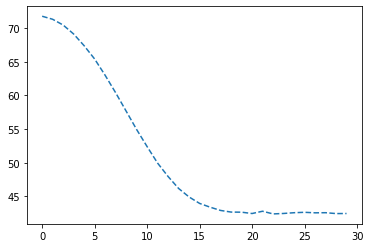

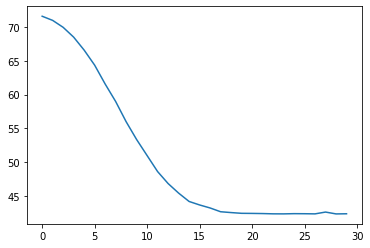

In [17]:
k = 5
n_simulations = 5
epochs = 200
batchsize = 128
sim_train = np.zeros((n_simulations, epochs))
sim_test = np.zeros((n_simulations, epochs))
simulation_list = []

for sim in range(n_simulations):
    model_sim_best, Ltrain, Ltest, lowest_val = LSTM(image_train, labels_train, epochs, k, batchsize, sim)
    
    # Testing model
    m_label = np.mean(image_test)
    s_label = np.std(image_test)
    X_model = norm(image_test, m_label, s_label)
    R = model_sim_best.evaluate(X_model, labels_test, verbose = 0)
    simulation_list.append(R[0])
    
    if sim == 0:
        model_best = model_sim_best
        val_marker = lowest_val
    else:
        if lowest_val < val_marker:
            model_best = model_sim_best
            val_marker = lowest_val
    
    sim_train[sim] = np.mean(Ltrain, axis = 0)
    sim_test[sim] = np.mean(Ltest, axis = 0)
    
    plt.figure(1)
    plt.plot(range(epochs), sim_train[sim], '--', label = 'Simulation {}'.format(sim+1))
    plt.figure(2)
    plt.plot(range(epochs), sim_test[sim], label = 'Simulation {}'.format(sim+1))

    
plt.figure(3)    
plt.plot(range(epochs), np.mean(sim_train, axis = 0), 'k--')
plt.figure(4)    
plt.plot(range(epochs), np.mean(sim_test, axis = 0), 'k')

clear_output()

titles = ['LSTM Simulation Training', 'LSTM Simulation Validation','LSTM Average Training', 'LSTM Average Validation']
for i in range(4):
    plt.figure(i+1)
    plt.title(titles[i])
    plt.xlabel('Epochs')
    plt.ylabel('Root Mean Square Error')
    if i == 0 or i == 1:     
        plt.legend()   
        
overfit = np.sqrt(simulation_list) - np.min(sim_train, axis = 1)        
train_min_mean = np.mean(np.min(sim_train, axis = 1))
train_min_std = np.std(np.min(sim_train, axis = 1))
test_min_mean = np.mean(np.min(sim_test, axis = 1))
test_min_std = np.std(np.min(sim_test, axis = 1))
print('Final Training Mean RMSE:',train_min_mean)
print('Final Training STD RMSE:',train_min_std)
print('Final Validation Mean RMSE:',test_min_mean)
print('Final Validation STD RMSE:',test_min_std)
print('The Final Mean RMSE', np.mean(np.sqrt(simulation_list)))
print('The Final STD RMSE', np.std(np.sqrt(simulation_list)))
print('Overfit Mean', np.mean(overfit))
print('Overfit STD', np.std(overfit))
#-----------------Saving model------------------
# serialize model to JSON
model_json = model_best.to_json()
with open("LSTM_model_best.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_best.save_weights("LSTM_model_best.h5")
print("Saved model to disk")

In [ ]:
def prune(model):
    epochs_prune = 1
    batch = 1000
    end_step = np.ceil(1.0 * len(image_train)/batch).astype(np.int32) * epochs_prune
    new_pruning_params = {'pruning_schedule': sparsity.PolynomialDecay(initial_sparsity = 0.25,
                                                       final_sparsity = 0.25,
                                                       begin_step = 0,
                                                       end_step = end_step,
                                                       frequency = 100)}

    new_pruned_model = sparsity.prune_low_magnitude(model, **new_pruning_params)
    new_pruned_model.compile(loss = tf.keras.losses.mean_squared_error, optimizer = 'adam', metrics=['mse'])
    callbacks = [sparsity.UpdatePruningStep()]
    new_pruned_model.fit(image_train, labels_train,
              batch_size = batch,
              epochs = epochs_prune,
              verbose = 1,
              callbacks = callbacks)
    #           validation_data = (x_val, y_val))

    clear_output()
    final_model = sparsity.strip_pruning(new_pruned_model)
    score = new_pruned_model.evaluate(image_test, labels_test, verbose = 0)
    print('initial test RMSE = {:.2f}'.format(np.mean(np.sqrt(simulation_list))))
    print('The final test RMSE on the model is {:.2f}'.format(np.sqrt(score[0])))
    
    return new_pruned_model

prune(model_best)